# 0) Carregamento as bibliotecas

In [1]:
# Mostra múltiplos resultados em uma única saída:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Math

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import pysal
from pyproj import CRS
from shapely.geometry import Point, MultiPoint, Polygon, mapping
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

C:\Users\Jorge\Anaconda3\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\Jorge\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# 1) Leitura dos Banco de Dados:

**(a) Dados SIH 2019:**

In [188]:
df = pd.read_csv("NT02 - Bahia/SIH/sih_17-19.csv")
#pickle.dump(df, open('sih_2019', 'wb'))

In [189]:
#df = pickle.load(open('sih_2019','rb'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2607955 entries, 0 to 2607954
Data columns (total 11 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   N_AIH       int64 
 1   MES_CMPT    int64 
 2   DT_INTER    int64 
 3   DT_SAIDA    int64 
 4   MUNIC_RES   int64 
 5   CEP         int64 
 6   MUNIC_MOV   int64 
 7   DIAG_PRINC  object
 8   PROC_REA    int64 
 9   COMPLEX     int64 
 10  QT_DIARIAS  int64 
dtypes: int64(10), object(1)
memory usage: 218.9+ MB


In [190]:
df.head()

,N_AIH,MES_CMPT,DT_INTER,DT_SAIDA,MUNIC_RES,CEP,MUNIC_MOV,DIAG_PRINC,PROC_REA,COMPLEX,QT_DIARIAS
0,2917103539460,1,20170109,20170111,290500,46300000,290500,K928,303070102,2,2
1,2917103539471,1,20170103,20170107,290500,46300000,290500,K929,303070102,2,4
2,2917103539504,1,20170108,20170110,290500,46300000,290500,K928,303070102,2,2
3,2917103539515,1,20170107,20170109,290500,46300000,290500,K928,303070102,2,2
4,2917103539526,1,20170108,20170110,290500,46300000,290500,K928,303070102,2,2


In [191]:
df.rename(columns={'MES_CMPT':'Mes','DT_INTER':'DT_Inter','DT_SAIDA':'DT_Saida','MUNIC_RES':'Cod_Municipio_Res',
                   'MUNIC_MOV':'Cod_Municipio','DIAG_PRINC':'Diagnostico','PROC_REA':'Procedimento','COMPLEX':'Complexidade',
                   'QT_DIARIAS':'Quantidade Diarias'}, inplace=True)

In [192]:
df = df.astype({'Cod_Municipio_Res': 'str','Cod_Municipio':'str','DT_Inter':'str','DT_Saida':'str',
                'Complexidade':'str','Procedimento':'str'})

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2607955 entries, 0 to 2607954
Data columns (total 11 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   N_AIH               int64 
 1   Mes                 int64 
 2   DT_Inter            object
 3   DT_Saida            object
 4   Cod_Municipio_Res   object
 5   CEP                 int64 
 6   Cod_Municipio       object
 7   Diagnostico         object
 8   Procedimento        object
 9   Complexidade        object
 10  Quantidade Diarias  int64 
dtypes: int64(4), object(7)
memory usage: 218.9+ MB


In [195]:
df['Complexidade'] = df['Complexidade'].replace(['2','3'],['Média','Alta'])

In [197]:
df.head()

,N_AIH,Mes,DT_Inter,DT_Saida,Cod_Municipio_Res,CEP,Cod_Municipio,Diagnostico,Procedimento,Complexidade,Quantidade Diarias
0,2917103539460,1,20170109,20170111,290500,46300000,290500,K928,303070102,Média,2
1,2917103539471,1,20170103,20170107,290500,46300000,290500,K929,303070102,Média,4
2,2917103539504,1,20170108,20170110,290500,46300000,290500,K928,303070102,Média,2
3,2917103539515,1,20170107,20170109,290500,46300000,290500,K928,303070102,Média,2
4,2917103539526,1,20170108,20170110,290500,46300000,290500,K928,303070102,Média,2


* **Formatação para datas:**

In [198]:
from datetime import datetime

In [199]:
df['DT_Inter'] = df['DT_Inter'].apply(lambda x: pd.to_datetime(x, format = '%Y%m%d'))

In [200]:
df['DT_Saida'] = df['DT_Saida'].apply(lambda x: pd.to_datetime(x, format = '%Y%m%d'))

In [201]:
pickle.dump(df, open('sih', 'wb'))

In [3]:
df = pickle.load(open('sih','rb'))

In [4]:
df2 = df.drop_duplicates(subset ="N_AIH",keep = 'last')

In [5]:
len(df2) #Total de internações em hospitais baianos

2579967

In [6]:
len(df2[df2['Cod_Municipio_Res'].str.startswith('29')]) # Internações em hospitais baianos de indivíduos que moram na bahia

2550223

In [7]:
2550223/2579967

0.988471170367683

**(b) Shape municípios:**

In [5]:
mun = gpd.read_file("NT02 - Bahia/mun_br.shp")
mun = mun.to_crs(CRS("WGS84"));
mun.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
mun.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NOME        5570 non-null   object  
 1   NOMEABREV   5570 non-null   object  
 2   GEOMETRIAA  5570 non-null   object  
 3   GEOCODIGO   5570 non-null   object  
 4   ANODEREFER  5570 non-null   int64   
 5   LoGVADBAgr  5547 non-null   float64 
 6   LogVADBInd  5550 non-null   float64 
 7   geometry    5570 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 348.2+ KB


In [7]:
mun.head()

,NOME,NOMEABREV,GEOMETRIAA,GEOCODIGO,ANODEREFER,LoGVADBAgr,LogVADBInd,geometry
0,Imbituba,Imbituba,Não,4207304,2013,7.46,8.24,"POLYGON Z ((-48.70366 -28.08714 0.00000, -48.7..."
1,São José de Ribamar,São José de Ribamar,Não,2111201,2013,7.31,8.40,"POLYGON Z ((-43.99993 -2.57867 0.00000, -43.99..."
2,Icatu,Icatu,Não,2105104,2013,7.33,6.71,"POLYGON Z ((-43.70784 -2.53885 0.00000, -43.70..."
3,Tacima,Tacima,Não,2516409,2013,6.71,6.29,"POLYGON Z ((-35.62790 -6.45162 0.00000, -35.62..."
4,Serra Caiada,Serra Caiada,Não,2410306,2013,6.47,6.35,"POLYGON Z ((-35.76942 -6.04778 0.00000, -35.76..."


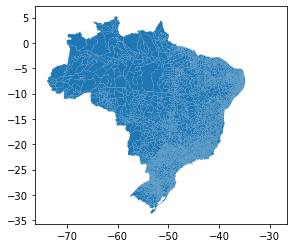

In [8]:
mun.plot();
plt.show();

In [9]:
mun_ba = mun[mun['GEOCODIGO'].str.startswith('29')].copy()

In [10]:
mun_ba.head()

,NOME,NOMEABREV,GEOMETRIAA,GEOCODIGO,ANODEREFER,LoGVADBAgr,LogVADBInd,geometry
97,Campo Formoso,Campo Formoso,Não,2906006,2013,7.62,8.04,"POLYGON Z ((-40.62844 -9.88565 0.00000, -40.31..."
99,Formosa do Rio Preto,Formosa do Rio Preto,Não,2911105,2013,9.00,7.96,"POLYGON Z ((-45.59474 -10.10948 0.00000, -45.5..."
104,Umburanas,Umburanas,Não,2932457,2013,7.28,6.75,"POLYGON Z ((-41.27952 -10.34242 0.00000, -41.2..."
114,Cotegipe,Cotegipe,Não,2909406,2013,7.64,6.69,"POLYGON Z ((-43.91408 -11.34009 0.00000, -43.9..."
117,Barreiras,Barreiras,Não,2903201,2013,8.87,8.64,"POLYGON Z ((-46.05951 -11.61710 0.00000, -46.0..."


In [11]:
mun_ba[mun_ba['GEOCODIGO'].str.startswith('290160')]

,NOME,NOMEABREV,GEOMETRIAA,GEOCODIGO,ANODEREFER,LoGVADBAgr,LogVADBInd,geometry
2041,Antas,Antas,Não,2901601,2013,7.14,6.63,"POLYGON Z ((-38.31346 -10.30962 0.00000, -38.3..."


In [12]:
mun_ba[mun_ba['NOME']=='Sítio do Quinto']
mun_ba[mun_ba['NOME']=='Antas']

,NOME,NOMEABREV,GEOMETRIAA,GEOCODIGO,ANODEREFER,LoGVADBAgr,LogVADBInd,geometry
2012,Sítio do Quinto,Sítio do Quinto,Não,2930766,2013,7.13,6.61,"POLYGON Z ((-38.17991 -10.18461 0.00000, -38.1..."


,NOME,NOMEABREV,GEOMETRIAA,GEOCODIGO,ANODEREFER,LoGVADBAgr,LogVADBInd,geometry
2041,Antas,Antas,Não,2901601,2013,7.14,6.63,"POLYGON Z ((-38.31346 -10.30962 0.00000, -38.3..."


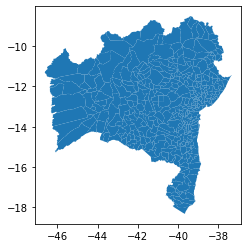

In [13]:
mun_ba.plot();
plt.show();

**Adicionando a população de 2019 (IBGE):**

In [10]:
pop = gpd.read_file('NT02 - Bahia/IBGE - Estimativa popul 2019.shp')

In [11]:
pop.head()

,MUNICIPIO,Codigo,p_pop_2019,geometry
0,Nova ViÃÂ§osa,2923001,43376,"POLYGON ((-39.70855 -17.77303, -39.70812 -17.7..."
1,Mucuri,2922003,41748,"POLYGON ((-40.21221 -17.73048, -40.21085 -17.7..."
2,IbirapoÃÂ£,2912806,8637,"POLYGON ((-40.14385 -17.62265, -40.14350 -17.6..."
3,Caravelas,2906907,22016,"POLYGON ((-40.22508 -17.40671, -40.22353 -17.4..."
4,LajedÃÂ£o,2918902,3955,"POLYGON ((-40.32401 -17.39604, -40.32253 -17.3..."


In [12]:
mun_ba['Pop'] = 0
for i, row in mun_ba.iterrows():
    mun_ba.loc[i,'Pop'] = pop[pop['Codigo']==row['GEOCODIGO']]['p_pop_2019'].values[0]

**Adicionando Casos até 24/04:**

In [9]:
casos = gpd.read_file('NT02 - Bahia/Evolução/data_shape_ba_mod(1).shp')

In [10]:
casos.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 53 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MUNICIPIO   417 non-null    object  
 1   Codigo      417 non-null    object  
 2   2020-03-06  1 non-null      float64 
 3   2020-03-07  1 non-null      float64 
 4   2020-03-08  1 non-null      float64 
 5   2020-03-09  1 non-null      float64 
 6   2020-03-10  1 non-null      float64 
 7   2020-03-11  1 non-null      float64 
 8   2020-03-12  1 non-null      float64 
 9   2020-03-13  2 non-null      float64 
 10  2020-03-14  2 non-null      float64 
 11  2020-03-15  2 non-null      float64 
 12  2020-03-16  3 non-null      float64 
 13  2020-03-17  4 non-null      float64 
 14  2020-03-18  4 non-null      float64 
 15  2020-03-19  6 non-null      float64 
 16  2020-03-20  7 non-null      float64 
 17  2020-03-21  7 non-null      float64 
 18  2020-03-22  9 non-null      float64 
 19  

In [11]:
mun_ba['c20200424'] = 0
for i, row in mun_ba.iterrows():
    mun_ba.loc[i,'c20200424'] = casos[casos['Codigo']==row['GEOCODIGO']]['2020-04-24'].values[0]

In [12]:
mun_ba['c20200424'] = mun_ba['c20200424'].fillna(0)

**Calculando prevalências (com base em 24/04):**

In [13]:
mun_ba['prev'] = (mun_ba['c20200424']/mun_ba['Pop'])*100000

In [14]:
mun_ba.sort_values(by='prev', ascending = False)

,NOME,NOMEABREV,GEOMETRIAA,GEOCODIGO,ANODEREFER,LoGVADBAgr,LogVADBInd,Pop,Qtd_Tot,Qtd_Fora,Qtd_CplxM,Qtd_CplxA,Dia_Tot,Dia_CplxM,Dia_CplxA,geometry,c20200424,prev
348,Ilhéus,Ilhéus,Não,2913606,2013,8.22,8.91,180213,17816,4461,17545,271,70427,69544,883,"POLYGON Z ((-39.34750 -14.45247 0.00000, -39.3...",134,74.356456
347,Uruçuca,Uruçuca,Não,2932705,2013,7.51,7.20,21849,0,0,0,0,0,0,0,"POLYGON Z ((-39.04297 -14.40252 0.00000, -39.0...",14,64.076159
329,Gongogi,Gongogi,Não,2911501,2013,7.36,6.45,8082,220,43,220,0,764,764,0,"POLYGON Z ((-39.66358 -14.18336 0.00000, -39.6...",4,49.492700
371,Itabuna,Itabuna,Não,2914802,2013,7.47,8.81,219680,20865,12283,19600,1265,96019,88112,7907,"POLYGON Z ((-39.28766 -14.69236 0.00000, -39.2...",104,47.341588
319,Barra do Rocha,Barra do Rocha,Não,2903102,2013,7.30,6.95,6424,0,0,0,0,0,0,0,"POLYGON Z ((-39.57369 -13.88967 0.00000, -39.5...",3,46.699875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Iaçu,Iaçu,Não,2911907,2013,7.77,7.18,26178,331,35,331,0,1173,1173,0,"POLYGON Z ((-39.84735 -12.51109 0.00000, -39.8...",0,0.000000
80,Várzea Nova,Várzea Nova,Não,2933158,2013,6.77,6.77,13470,1054,68,1054,0,3170,3170,0,"POLYGON Z ((-41.12670 -11.00074 0.00000, -41.1...",0,0.000000
209,Boquira,Boquira,Não,2904100,2013,7.10,6.82,22429,660,4,660,0,2220,2220,0,"POLYGON Z ((-42.64320 -12.50693 0.00000, -42.6...",0,0.000000
1,Formosa do Rio Preto,Formosa do Rio Preto,Não,2911105,2013,9.00,7.96,25372,1628,14,1628,0,4925,4925,0,"POLYGON Z ((-45.59474 -10.10948 0.00000, -45.5...",0,0.000000


# (2) Internações nos Hospitais BA

**(a) Quantidade de indivíduos:**

In [16]:
mun_ba['Qtd_Tot'] = 0
mun_ba['Qtd_Fora'] = 0
mun_ba['Qtd_CplxM'] = 0
mun_ba['Qtd_CplxA'] = 0
mun_ba['Dia_Tot'] = 0
mun_ba['Dia_CplxM'] = 0
mun_ba['Dia_CplxA'] = 0

**Período de 01/07/2018 a 30/06/2019:**

In [19]:
from datetime import date

In [20]:
per = pd.date_range(date(2018,7,1), periods=365).tolist()

In [21]:
per[0]
per[-1]

Timestamp('2018-07-01 00:00:00', freq='D')

Timestamp('2019-06-30 00:00:00', freq='D')

In [22]:
# Entraram em alguma data até 30/06/2019 e saíram entre 01/07/2018 até 30/06/2019
df_BA = df2[(df2['DT_Inter'] <= per[-1]) & (df2['DT_Saida'] >= per[0]) & (df2['DT_Saida'] <= per[-1])]

In [23]:
#df_BA = df2[(df2['Cod_Municipio'].str.startswith('29')) & (df2['Cod_Municipio_Res'].str.startswith('29'))].copy()

In [24]:
df_BA.head()

,N_AIH,Mes,DT_Inter,DT_Saida,Cod_Municipio_Res,CEP,Cod_Municipio,Diagnostico,Procedimento,Complexidade,Quantidade Diarias
1212741,2918106396986,7,2018-07-23,2018-07-24,291070,48500000,292740,N394,409070270,Média,1
1212742,2918106396997,7,2018-07-22,2018-07-24,292950,43850000,292740,K602,407020217,Média,2
1212743,2918106397063,7,2018-07-17,2018-07-19,291270,45500000,292740,K802,407030034,Média,2
1212744,2918106397096,7,2018-07-16,2018-07-19,292740,40725200,292740,D259,409060135,Média,3
1212745,2918106467881,7,2018-07-22,2018-07-25,292740,41385380,292740,K808,407030034,Média,3


In [25]:
for i, row in mun_ba.iterrows():
    mun_ba.loc[i,'Qtd_Tot'] = len(df_BA[df_BA['Cod_Municipio']==row['GEOCODIGO'][:-1]])
    mun_ba.loc[i,'Qtd_Fora'] = len(df_BA[(df_BA['Cod_Municipio']==row['GEOCODIGO'][:-1]) & (df2['Cod_Municipio_Res']!=row['GEOCODIGO'][:-1])])
    mun_ba.loc[i,'Qtd_CplxM'] = len(df_BA[(df_BA['Cod_Municipio']==row['GEOCODIGO'][:-1]) & 
                                   (df_BA['Complexidade']=='Média')])
    mun_ba.loc[i,'Qtd_CplxA'] = len(df_BA[(df_BA['Cod_Municipio']==row['GEOCODIGO'][:-1]) & 
                                   (df_BA['Complexidade']=='Alta')])
    mun_ba.loc[i,'Dia_Tot'] = df_BA[df_BA['Cod_Municipio']==row['GEOCODIGO'][:-1]]['Quantidade Diarias'].sum()
    mun_ba.loc[i,'Dia_CplxM'] = df_BA[(df_BA['Cod_Municipio']==row['GEOCODIGO'][:-1]) & 
                                   (df_BA['Complexidade']=='Média')]['Quantidade Diarias'].sum()
    mun_ba.loc[i,'Dia_CplxA'] = df_BA[(df_BA['Cod_Municipio']==row['GEOCODIGO'][:-1]) & 
                                   (df_BA['Complexidade']=='Alta')]['Quantidade Diarias'].sum()

C:\Users\Jorge\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


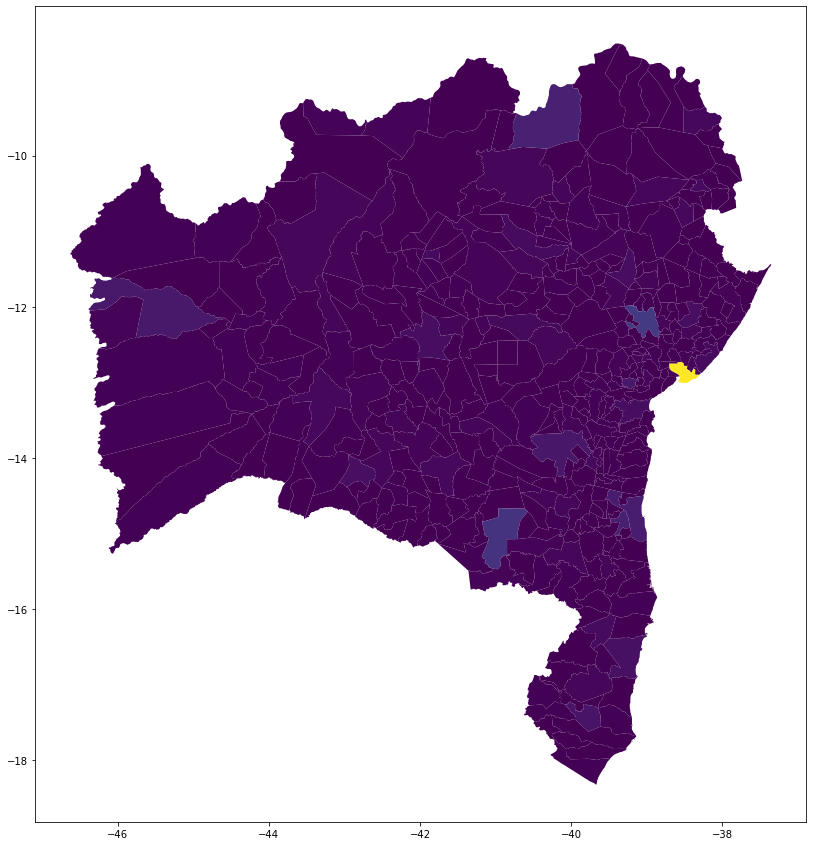

In [26]:
fig, ax = plt.subplots(figsize=(15,15));
mun_ba.plot(ax = ax, column = 'Qtd_Tot');

In [27]:
mun_ba.to_file('NT02 - Bahia/intern_ba.shp')

In [8]:
mun_ba = gpd.read_file('NT02 - Bahia/intern_ba.shp')

# (3) Internações por dia em cada município

In [28]:
from datetime import date

In [29]:
datas = pd.date_range(date(2018,7,1), periods=365).tolist()

In [30]:
lst_mun_ba = list(mun_ba['GEOCODIGO'].apply(lambda x: x[:-1]).values)

In [34]:
datas[0]
datas[-1]

Timestamp('2018-07-01 00:00:00', freq='D')

Timestamp('2019-06-30 00:00:00', freq='D')

In [35]:
# Entraram em alguma data até 30/06/2019 e saíram entre 01/07/2018 até 30/06/2019
df2[(df2['DT_Inter'] <= datas[-1]) & (df2['DT_Saida'] >= datas[0]) & (df2['DT_Saida'] <= datas[-1]) & (df2['Cod_Municipio'] == '292740')]

,N_AIH,Mes,DT_Inter,DT_Saida,Cod_Municipio_Res,CEP,Cod_Municipio,Diagnostico,Procedimento,Complexidade,Quantidade Diarias
1212741,2918106396986,7,2018-07-23,2018-07-24,291070,48500000,292740,N394,409070270,Média,1
1212742,2918106396997,7,2018-07-22,2018-07-24,292950,43850000,292740,K602,407020217,Média,2
1212743,2918106397063,7,2018-07-17,2018-07-19,291270,45500000,292740,K802,407030034,Média,2
1212744,2918106397096,7,2018-07-16,2018-07-19,292740,40725200,292740,D259,409060135,Média,3
1212745,2918106467881,7,2018-07-22,2018-07-25,292740,41385380,292740,K808,407030034,Média,3
...,...,...,...,...,...,...,...,...,...,...,...
2375166,2919106085478,11,2019-05-21,2019-06-25,292740,40370120,292740,C168,416040071,Alta,11
2378996,2919100780630,11,2019-05-31,2019-06-03,291920,42700000,292740,J81,303060131,Média,3
2405343,2919100261704,11,2019-06-11,2019-06-13,292740,40231025,292740,D391,415020050,Alta,2
2405344,2919100280811,11,2019-06-17,2019-06-20,290960,48480970,292740,C187,415020050,Alta,3


In [36]:
ssa = []
for dt in datas:
    ssa.append(len(df2[(df2['DT_Inter'] <= dt) & (df2['DT_Saida'] >= dt) & (df2['Cod_Municipio'] == '292740')]))

In [37]:
pd_ssa = pd.DataFrame(zip(ssa,datas), columns = ['intern', 'data'])

In [38]:
pd_ssa['datas'] = pd.to_datetime(pd_ssa['data'])

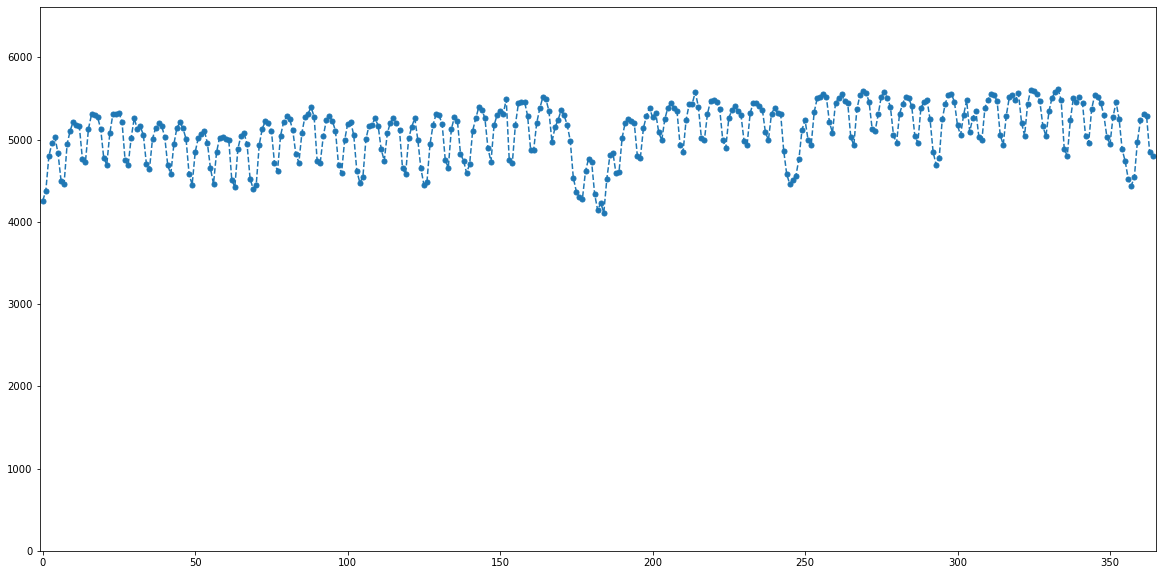

In [39]:
pd_ssa['intern'].plot(figsize = (20,10), style = 'o--', markersize = 5);
plt.ylim(0,max(pd_ssa['intern'])+1000);
plt.xlim(-1,365);
plt.show();

In [40]:
max(ssa)
min(ssa)

5609

4108

* **Série temporal para todos os municípios:**

In [174]:
ba_int = pd.DataFrame(index=datas, columns=mun_ba['GEOCODIGO'].apply(lambda x: x[:-1]).values)

In [177]:
list_mun = list(mun_ba['GEOCODIGO'].apply(lambda x: x[:-1]).values)
for i, row in ba_int.iterrows():
    for mun in list_mun:
        row[mun] = len(df2[(df2['DT_Inter'] <= i) & (df2['DT_Saida'] >= i) & (df2['Cod_Municipio'] == mun)])

In [178]:
ba_int

,290600,291110,293245,290940,290320,291735,290810,290689,293300,291075,...,291600,293325,292550,292110,293135,291890,290690,291280,292200,292300
2018-01-01,32,5,0,0,204,4,5,0,5,0,...,8,1,7,7,118,0,4,0,3,4
2018-01-02,35,9,0,0,229,5,6,0,5,0,...,11,1,5,5,139,0,6,0,3,7
2018-01-03,34,14,0,0,246,4,5,0,4,0,...,15,1,8,8,137,0,4,0,8,13
2018-01-04,42,19,0,0,249,6,7,0,4,0,...,15,2,9,13,164,0,4,0,8,20
2018-01-05,36,18,0,0,242,5,9,0,4,0,...,9,3,7,14,174,0,6,0,7,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,30,10,0,0,214,8,21,0,11,0,...,14,3,6,12,148,0,5,3,11,11
2018-12-28,37,10,0,0,210,7,19,0,9,0,...,14,3,5,10,135,0,5,5,10,7
2018-12-29,31,10,0,0,212,9,12,0,9,0,...,11,3,7,12,120,0,5,5,7,4
2018-12-30,28,10,0,0,204,7,9,0,9,0,...,7,1,5,10,111,0,6,6,3,2


In [205]:
ba_int.to_excel('NT02 - Bahia/ba_int_dia.xlsx')

# (4) Padrão Origem-Destino das Internações 

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2607955 entries, 0 to 2607954
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   N_AIH               int64         
 1   Mes                 int64         
 2   DT_Inter            datetime64[ns]
 3   DT_Saida            datetime64[ns]
 4   Cod_Municipio_Res   object        
 5   CEP                 int64         
 6   Cod_Municipio       object        
 7   Diagnostico         object        
 8   Procedimento        object        
 9   Complexidade        object        
 10  Quantidade Diarias  int64         
dtypes: datetime64[ns](2), int64(4), object(5)
memory usage: 218.9+ MB


In [207]:
per = pd.date_range(date(2018,7,1), periods=365).tolist()

In [208]:
per[0]
per[-1]

Timestamp('2018-07-01 00:00:00', freq='D')

Timestamp('2019-06-30 00:00:00', freq='D')

In [209]:
# Entraram em alguma data até 30/06/2019 e saíram entre 01/07/2018 até 30/06/2019
df_BA = df2[(df2['DT_Inter'] <= per[-1]) & (df2['DT_Saida'] >= per[0]) & (df2['DT_Saida'] <= per[-1]) & (df2['Cod_Municipio_Res'].str.startswith('29'))]

In [210]:
#df_BA = df2[(df2['Cod_Municipio'].str.startswith('29')) & (df2['Cod_Municipio_Res'].str.startswith('29'))].copy()

In [211]:
df_BA['Quantidade'] = 1

C:\Users\Jorge\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [212]:
df_BA.groupby(['Cod_Municipio_Res','Cod_Municipio']).sum()

N_AIH    Mes           CEP  \
Cod_Municipio_Res Cod_Municipio                                          
290010            290280            8755319714472     21     140070000   
                  291080           11674425430713     18     186761940   
                  291320            2918108068018     10      46690000   
                  291440            8755319624249     21     140085000   
                  291800            2919102478875      1      46690000   
...                                           ...    ...           ...   
293360            292810            5836217813173     12      94800000   
                  292870            5838208745611      8      94800000   
                  292990            5838205185912     14      94800000   
                  293340            2919106075875      5      47400000   
                  293360         6593244503453734  13896  107076600000   

                                 Quantidade Diarias  Quantidade  
Cod_Municipio_Res Cod_Municipio                                  
290010            290280                          7           3  
                  291080                         35           4  
                  291320                          1           1  
                  291440                          4           3  
                  291800                          3           1  
...                                             ...         ...  
293360            292810                          6           2  
                  292870                         13           2  
                  292990                          2           2  
                  293340                          2           1  
                  293360                       7569        2259  

[6579 rows x 5 columns]

In [213]:
df_BA['Quantidade'].sum()

827386

In [214]:
tab = df_BA.groupby(['Cod_Municipio_Res','Cod_Municipio']).sum()

In [9]:
tab_OD = pd.DataFrame(columns = ['ORI','DES','Qtd','Dia','Qtd_Dia'])

In [216]:
tab_OD

,ORI,DES,Qtd,Dia,Qtd_Dia


In [217]:
tab.index[0][1]

'290280'

In [218]:
for i in np.arange(len(tab)):
    ORI = tab.index[i][0]
    DES = tab.index[i][1]
    Qtd = tab.loc[tab.index[i],'Quantidade']
    Dia = tab.loc[tab.index[i],'Quantidade Diarias']
    Qtd_Dia = tab.loc[tab.index[i],'Quantidade']*tab.loc[tab.index[i],'Quantidade Diarias']
    tab_OD.loc[i] = [ORI, DES, Qtd, Dia, Qtd_Dia]

In [219]:
tab_OD

,ORI,DES,Qtd,Dia,Qtd_Dia
0,290010,290280,3,7,21
1,290010,291080,4,35,140
2,290010,291320,1,1,1
3,290010,291440,3,4,12
4,290010,291800,1,3,3
...,...,...,...,...,...
6574,293360,292810,2,6,12
6575,293360,292870,2,13,26
6576,293360,292990,2,2,4
6577,293360,293340,1,2,2


In [220]:
tab_OD['ORI_GC'] = 0
tab_OD['DES_GC'] = 0

In [221]:
for i, el in enumerate(zip(tab_OD['ORI'],tab_OD['DES'])):
    tab_OD.loc[i,'ORI_GC'] = mun_ba[mun_ba['GEOCODIGO'].str.startswith(str(el[0]))]['GEOCODIGO'].values[0]
    tab_OD.loc[i,'DES_GC'] = mun_ba[mun_ba['GEOCODIGO'].str.startswith(str(el[1]))]['GEOCODIGO'].values[0]

In [222]:
tab_OD['Qtd'] = pd.to_numeric(tab_OD['Qtd'])
tab_OD['Dia'] = pd.to_numeric(tab_OD['Dia'])
tab_OD['Qtd_Dia'] = pd.to_numeric(tab_OD['Qtd_Dia'])
tab_OD.head()
tab_OD.info()

,ORI,DES,Qtd,Dia,Qtd_Dia,ORI_GC,DES_GC
0,290010,290280,3,7,21,2900108,2902807
1,290010,291080,4,35,140,2900108,2910800
2,290010,291320,1,1,1,2900108,2913200
3,290010,291440,3,4,12,2900108,2914406
4,290010,291800,1,3,3,2900108,2918001


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6579 entries, 0 to 6578
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ORI      6579 non-null   object
 1   DES      6579 non-null   object
 2   Qtd      6579 non-null   int64 
 3   Dia      6579 non-null   int64 
 4   Qtd_Dia  6579 non-null   int64 
 5   ORI_GC   6579 non-null   object
 6   DES_GC   6579 non-null   object
dtypes: int64(3), object(4)
memory usage: 731.2+ KB


In [223]:
tab_OD.to_excel('NT02 - Bahia/tab_OD.xlsx', index = False)

In [14]:
tab_OD = pd.read_excel('NT02 - Bahia/tab_OD.xlsx')

In [271]:
tab_OD_dif = tab_OD[tab_OD['ORI'] != tab_OD['DES']].copy()

In [272]:
tab_OD_dif.to_excel('NT02 - Bahia/tab_OD_dif.xlsx', index = False)

In [273]:
tab_OD_dif.sort_values(by='Qtd', ascending = False).head(20)[['ORI_GC','DES_GC','Qtd','Dia','Qtd_Dia']]

,ORI_GC,DES_GC,Qtd,Dia,Qtd_Dia
3530,2919207,2927408,6143,30897,189800271
1009,2905701,2927408,5135,27868,143102180
5917,2930709,2927408,3768,21483,80947944
1930,2910800,2927408,2389,16466,39337274
1149,2906501,2927408,1980,9977,19754460
1740,2910057,2927408,1529,7861,12019469
104,2900702,2927408,1432,7216,10333312
6438,2933208,2916104,1063,3136,3333568
3859,2921005,2927408,1009,4984,5028856
3184,2917508,2927408,965,6640,6407600


### (4.1) Principais centros de internação hospitalar (origens mais demandadas)

In [12]:
tab_OD.groupby(['DES_GC']).sum().sort_values(by='Qtd', ascending = False)['Qtd'].sum()

827386

In [13]:
tab_OD.groupby(['DES_GC']).sum().sort_values(by='Qtd', ascending = False)[:20]

,ORI,DES,Qtd,Dia,Qtd_Dia,ORI_GC
DES_GC,,,,,,
2927408,121353095,121779840,233512,1308269,130325268602,1213532855
2910800,94525931,94309920,38820,201859,3406921680,945260717
2933307,53372813,53679390,34452,154296,1965769759,533728981
2914802,41714453,41681640,20688,95147,375811145,417145167
2913606,32091899,32049600,17784,70285,680243849,320919481
2918407,16630924,16634880,15618,72322,535380897,166309503
2928703,56610916,56816780,14941,54936,118388061,566109973
2903201,20422264,20322400,14844,65301,332719005,204222952
2918001,38211132,38225800,13998,67418,323215475,382111904


Proporção:

In [14]:
tab_OD.groupby(['DES_GC']).sum().sort_values(by='Qtd', ascending = False)[:50]['Qtd']/tab_OD.groupby(['DES_GC']).sum().sort_values(by='Qtd', ascending = False)['Qtd'].sum()
(tab_OD.groupby(['DES_GC']).sum().sort_values(by='Qtd', ascending = False)[:50]['Qtd']/tab_OD.groupby(['DES_GC']).sum().sort_values(by='Qtd', ascending = False)['Qtd'].sum()).sum()

DES_GC
2927408    0.282229
2910800    0.046919
2933307    0.041640
2914802    0.025004
2913606    0.021494
2918407    0.018876
2928703    0.018058
2903201    0.017941
2918001    0.016918
2931350    0.015143
2925303    0.011869
2911709    0.010357
2900702    0.010111
2908408    0.009700
2929909    0.009685
2932903    0.008911
2914604    0.008666
2901601    0.008214
2905701    0.008145
2910727    0.008103
2917508    0.007935
2927200    0.006710
2903904    0.006477
2926608    0.006437
2904605    0.006081
2929008    0.005820
2919207    0.005769
2913903    0.005551
2924009    0.005533
2909802    0.005463
2902708    0.005393
2930709    0.005306
2910701    0.005245
2916401    0.005033
2922508    0.004948
2907509    0.004798
2905206    0.004689
2906006    0.004656
2921203    0.004629
2915601    0.004463
2913507    0.004443
2908903    0.004407
2914703    0.004281
2930501    0.004279
2926301    0.004235
2925105    0.004152
2914406    0.004090
2923605    0.003949
2913200    0.003760
2930105    0.

0.7501504739021448

### (4.2) Municípios mais atendidos pelos principais centros de internação hospitalar

In [22]:
mun_ba.loc[mun_ba['GEOCODIGO'].isin(tab_OD['DES_GC'].astype(str))][['NOME','NOMEABREV','geometry']]

,NOME,NOMEABREV,geometry
0,Campo Formoso,Campo Formoso,"POLYGON Z ((-40.62844 -9.88565 0.00000, -40.31..."
1,Formosa do Rio Preto,Formosa do Rio Preto,"POLYGON Z ((-45.59474 -10.10948 0.00000, -45.5..."
4,Barreiras,Barreiras,"POLYGON Z ((-46.05951 -11.61710 0.00000, -46.0..."
5,Jaborandi,Jaborandi,"POLYGON Z ((-44.29372 -13.39707 0.00000, -44.2..."
6,Cocos,Cocos,"POLYGON Z ((-44.79454 -13.82584 0.00000, -44.7..."
...,...,...,...
411,Teixeira de Freitas,Teixeira de Freitas,"POLYGON Z ((-40.00720 -17.23299 0.00000, -40.0..."
413,Caravelas,Caravelas,"MULTIPOLYGON Z (((-39.19801 -17.76115 0.00000,..."
414,Ibirapuã,Ibirapuã,"POLYGON Z ((-40.15108 -17.62215 0.00000, -40.1..."
415,Mucuri,Mucuri,"POLYGON Z ((-40.21266 -17.73110 0.00000, -40.2..."


In [23]:
idx = list(tab_OD.groupby(['DES_GC']).sum().sort_values(by='Qtd', ascending = False)[:10]['Qtd'].index)

20 municípios mais atendidos dos 10 maiores centros de atendimento

In [365]:
for k in np.arange(len(idx)):
    mun_ba[mun_ba['GEOCODIGO']==idx[k]]['NOME'].values[0] #Nome
    tab_OD[tab_OD['DES_GC']==idx[k]].sort_values(by='Qtd', ascending = False)['Qtd'].sum() #Quantidade de internações
    tab_OD[tab_OD['DES_GC']==idx[k]].sort_values(by='Qtd', ascending = False)['Qtd'][:20].sum() \
    /tab_OD[tab_OD['DES_GC']==idx[k]].sort_values(by='Qtd', ascending = False)['Qtd'].sum() # Percentual de internações que estes 20 representam
    

'Salvador'

233512

0.7924218027339066

'Feira de Santana'

38820

0.8283616692426584

'Vitória da Conquista'

34452

0.8492104957622199

'Itabuna'

20688

0.80346094354215

'Ilhéus'

17784

0.9601327035537562

'Juazeiro'

15618

0.983224484569087

'Santo Antônio de Jesus'

14941

0.8178167458670772

'Barreiras'

14844

0.9308811641067097

'Jequié'

13998

0.9194884983569082

'Teixeira de Freitas'

12529

0.998563333067284

In [381]:
mun_ba[mun_ba['GEOCODIGO']==idx[0]]['NOME']

225    Salvador
Name: NOME, dtype: object

In [382]:
tab_OD[tab_OD['DES_GC']==idx[0]].sort_values(by='Qtd', ascending = False)['ORI_GC'][:20].values

array(['2927408', '2919207', '2905701', '2930709', '2910800', '2906501',
       '2910057', '2900702', '2921005', '2917508', '2933208', '2929503',
       '2928604', '2929206', '2908408', '2907509', '2928703', '2930501',
       '2918001', '2914604'], dtype=object)

In [481]:
atend = []
for k in np.arange(len(idx)):
    idx_mun = tab_OD[tab_OD['DES_GC']==idx[k]].sort_values(by='Qtd', ascending = False)['ORI_GC'][:20].values
    int_mun = tab_OD[tab_OD['DES_GC']==idx[k]].sort_values(by='Qtd', ascending = False)['Qtd'][:20].values
    nome_mun = list(map(lambda x: mun_ba[mun_ba['GEOCODIGO']==x]['NOME'].values[0], idx_mun))
    #pd.DataFrame(zip(idx_mun,nome_mun,int_mun), columns = ['Geocódigo','Município','Internações'])
    for i in idx_mun:
        atend.append(i)

In [484]:
len(atend)
len(list(set(atend)))

200

179

In [485]:
atend = list(set(atend))

In [488]:
mun_ba[mun_ba['GEOCODIGO'].isin(atend)]['Pop'].sum()
mun_ba[mun_ba['GEOCODIGO'].isin(atend)]['Pop'].sum()/mun_ba['Pop'].sum()

10890128

0.716251186667598

### (4.3) Análise da Pandemia no NRS Sul:

**Núcleos Regionais de Saúde:**

In [15]:
nrs = gpd.read_file('NT02 - Bahia/Oferta Hospitalar/SESAB - NUCLEO REG SAUDE - 20190514 - SIRGAS2000.shp')

In [16]:
nrs = nrs.to_crs(CRS("WGS84"));
nrs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
mun_ba.crs == nrs.crs

True

In [18]:
nrs

,CD_NRS,NM_NRS,geometry
0,2.0,Centro-norte,"POLYGON ((-41.39304 -11.77157, -41.39312 -11.7..."
1,7.0,Oeste,"POLYGON ((-44.41160 -14.28186, -44.41260 -14.2..."
2,4.0,Leste,"MULTIPOLYGON (((-39.89945 -12.93345, -39.89980..."
3,6.0,Norte,"POLYGON ((-40.01885 -10.88398, -40.01744 -10.9..."
4,3.0,Extremo sul,"POLYGON ((-39.26501 -17.84073, -39.26500 -17.8..."
5,1.0,Centro-leste,"POLYGON ((-41.60520 -13.42485, -41.60533 -13.4..."
6,8.0,Sudoeste,"POLYGON ((-39.83019 -15.53178, -39.83018 -15.5..."
7,9.0,Sul,"POLYGON ((-38.97375 -15.38551, -38.97375 -15.3..."
8,5.0,Nordeste,"POLYGON ((-37.94431 -12.37673, -37.94422 -12.3..."


In [19]:
mun_ba['NRS'] = 0
for i in list(nrs.index):
    mun_ba.loc[mun_ba['geometry'].apply(lambda x: x.centroid.within(nrs.loc[i,'geometry'])),'NRS'] = nrs.loc[i,'NM_NRS']

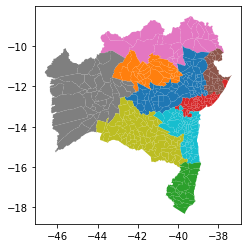

In [20]:
mun_ba.plot(column = 'NRS');
plt.show();

População

In [21]:
for i in nrs['NM_NRS'].values:
    print(i,mun_ba[mun_ba['NRS']==i]['Pop'].sum())

Centro-norte 829076
Oeste 967197
Leste 4801201
Norte 1105695
Extremo sul 840325
Centro-leste 2273262
Sudoeste 1816387
Sul 1689265
Nordeste 881934


In [22]:
mun_ba['Qtd_Tot'].sum()

837329

In [113]:
nrs.to_file('NT02 - Bahia/nrs.shp')

**Municípios com maior prevalência:**

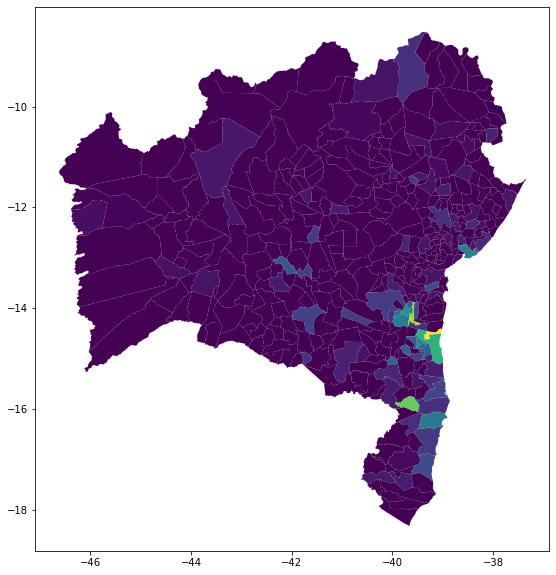

In [143]:
fig, ax = plt.subplots(figsize=(10,10));
mun_ba.plot(ax = ax, column = 'prev');
plt.show();

In [23]:
# 20 maiores do Estado:
mun_ba.sort_values(by='prev', ascending = False)[['GEOCODIGO','NOME','Pop','prev','NRS']][:20]

,GEOCODIGO,NOME,Pop,prev,NRS
348,2913606,Ilhéus,180213,74.356456,Sul
347,2932705,Uruçuca,21849,64.076159,Sul
329,2911501,Gongogi,8082,49.492700,Sul
371,2914802,Itabuna,219680,47.341588,Sul
319,2903102,Barra do Rocha,6424,46.699875,Sul
397,2916302,Itapebi,10882,45.947436,Extremo sul
225,2927408,Salvador,2921087,41.696807,Leste
354,2908002,Coaraci,19770,40.465352,Sul
327,2915205,Itagibá,15767,38.054164,Sul
351,2915502,Itajuípe,21754,36.774846,Sul


In [27]:
# Quantidade de municípios no NRS Sul que já possuem casos confirmados até 24/04/2020
len(mun_ba[(mun_ba['NRS']=='Sul') & (mun_ba['c20200424']>0)])

32

In [24]:
# 10 maiores da Região Sul:
mun_ba[mun_ba['NRS']=='Sul'].sort_values(by='prev', ascending = False)[['GEOCODIGO','NOME','prev']][:14]

,GEOCODIGO,NOME,prev
348,2913606,Ilhéus,74.356456
347,2932705,Uruçuca,64.076159
329,2911501,Gongogi,49.492700
371,2914802,Itabuna,47.341588
319,2903102,Barra do Rocha,46.699875
354,2908002,Coaraci,40.465352
327,2915205,Itagibá,38.054164
351,2915502,Itajuípe,36.774846
280,2909505,Cravolândia,35.971223
322,2913903,Ipiaú,33.683501


### (4.4) Oferta Hospitalar no NRS Sul

**Leitos convencionais:**

In [30]:
leitos = pd.read_excel('NT02 - Bahia/Oferta Hospitalar/leitos.xlsx')

In [31]:
leitos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   GEOCODIGO              343 non-null    int64
 1   Cirúrgicos             343 non-null    int64
 2   Clínicos               343 non-null    int64
 3   Obstétrico             343 non-null    int64
 4   Pediátrico             343 non-null    int64
 5   Outras Especialidades  343 non-null    int64
 6   HospitalDIA            343 non-null    int64
dtypes: int64(7)
memory usage: 18.9 KB


In [32]:
leitos.head(2)

,GEOCODIGO,Cirúrgicos,Clínicos,Obstétrico,Pediátrico,Outras Especialidades,HospitalDIA
0,290010,0,4,2,3,0,0
1,290020,2,8,8,6,0,0


**Leitos complementares:**

In [33]:
leitos_c = pd.read_excel('NT02 - Bahia/Oferta Hospitalar/leitos_comp.xlsx')

In [34]:
leitos_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 18 columns):
 #   Column                                              Non-Null Count  Dtype
---  ------                                              --------------  -----
 0   GEOCODIGO                                           119 non-null    int64
 1   Unidade isolamento                                  119 non-null    int64
 2   UTI adulto I                                        119 non-null    int64
 3   UTI adulto II                                       119 non-null    int64
 4   UTI adulto III                                      119 non-null    int64
 5   UTI pediátrica I                                    119 non-null    int64
 6   UTI pediátrica II                                   119 non-null    int64
 7   UTI pediátrica III                                  119 non-null    int64
 8   UTI neonatal I                                      119 non-null    int64
 9   UTI neonatal II      

In [35]:
leitos_c.head(2)

,GEOCODIGO,Unidade isolamento,UTI adulto I,UTI adulto II,UTI adulto III,UTI pediátrica I,UTI pediátrica II,UTI pediátrica III,UTI neonatal I,UTI neonatal II,UTI neonatal III,UTI de Queimados,UTI coronariana tipo II -UCO tipo II,UTI coronariana tipo III - UCO tipo III,Unidade de cuidados intermed neonatal convencional,Unidade de cuidados intermed neonatal canguru,Unidade de cuidados intermed pediatrico,Unidade de cuidados intermed adulto
0,290010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,290070,7,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Leitos adicionados pós COVID:**

In [36]:
leitos_add = pd.read_excel('NT02 - Bahia/Oferta Hospitalar/leitos_add.xlsx')

In [37]:
leitos_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MUNICIPIO  44 non-null     object
 1   HOSPITAL   44 non-null     object
 2   L_Clin     44 non-null     int64 
 3   L_UTI_Adu  44 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.5+ KB


In [38]:
leitos_add.head(2)

,MUNICIPIO,HOSPITAL,L_Clin,L_UTI_Adu
0,Santo Antonio de Jesus,Hospital Regional Santo Antônio de Jesus,0,0
1,Salvador,Instituto Couto Maia,0,50


**Respiradores:**

In [39]:
resp = pd.read_excel('NT02 - Bahia/Oferta Hospitalar/respiradores.xlsx')

In [40]:
resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   GEOCODIGO                189 non-null    int64
 1   Equipamentos_Existentes  189 non-null    int64
 2   Equipamentos_em_Uso      189 non-null    int64
 3   Estab_c/_Equip_SUS       189 non-null    int64
dtypes: int64(4)
memory usage: 6.0 KB


In [41]:
resp.head(2)

,GEOCODIGO,Equipamentos_Existentes,Equipamentos_em_Uso,Estab_c/_Equip_SUS
0,290060,1,1,1
1,290070,48,48,8


**Profissionais:**

In [42]:
prof = pd.read_excel('NT02 - Bahia/Oferta Hospitalar/profissionais.xlsx')

In [43]:
prof.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   GEOCODIGO                     414 non-null    int64
 1   Médico pneumologista          414 non-null    int64
 2   Médico da Família             414 non-null    int64
 3   Médico em Medicina Intensiva  414 non-null    int64
 4   Enfermeiro                    414 non-null    int64
 5   Fisioterapeuta                414 non-null    int64
 6   Nutricionista                 414 non-null    int64
dtypes: int64(7)
memory usage: 22.8 KB


In [44]:
prof.head(2)

,GEOCODIGO,Médico pneumologista,Médico da Família,Médico em Medicina Intensiva,Enfermeiro,Fisioterapeuta,Nutricionista
0,290010,0,3,0,10,5,2
1,290020,0,3,0,18,4,2


**Adicionando à `mun_ba`:**

In [45]:
mun_ba['L_Clin'] = 0
mun_ba['L_UTI_Adu'] = 0
mun_ba['L_UTI_Ped'] = 0
mun_ba['L_CInt_Adu'] = 0
mun_ba['L_CInt_Ped'] = 0
mun_ba['LA_Clin'] = 0
mun_ba['LA_UTI_Adu'] = 0
mun_ba['Resp'] = 0
mun_ba['M_Pneumo'] = 0
mun_ba['M_Familia'] = 0
mun_ba['M_Intens'] = 0
mun_ba['Enferm'] = 0
mun_ba['Fisiot'] = 0
mun_ba['Nutric'] = 0

In [46]:
for i, row in mun_ba.iterrows():
    try:
        mun_ba.loc[i,'L_Clin'] = leitos[leitos['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['Clínicos'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'L_UTI_Adu'] = leitos_c[leitos_c['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['UTI adulto I'].values[0] + leitos_c[leitos_c['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['UTI adulto II'].values[0] + leitos_c[leitos_c['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['UTI adulto III'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'L_UTI_Ped'] = leitos_c[leitos_c['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['UTI pediátrica I'].values[0] + leitos_c[leitos_c['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['UTI pediátrica II'].values[0] + leitos_c[leitos_c['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['UTI pediátrica III'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'L_CInt_Adu'] = leitos_c[leitos_c['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['Unidade de cuidados intermed adulto'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'L_CInt_Ped'] = leitos_c[leitos_c['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['Unidade de cuidados intermed pediatrico'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'LA_Clin'] = leitos_add[leitos_add['MUNICIPIO']==row['NOME']]['L_Clin'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'LA_UTI_Adu'] = leitos_add[leitos_add['MUNICIPIO']==row['NOME']]['L_UTI_Adu'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'Resp'] = resp[resp['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['Equipamentos_Existentes'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'M_Pneumo'] = prof[prof['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['Médico pneumologista'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'M_Familia'] = prof[prof['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['Médico da Família'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'M_Intens'] = prof[prof['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['Médico em Medicina Intensiva'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'Enferm'] = prof[prof['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['Enfermeiro'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'Fisiot'] = prof[prof['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['Fisioterapeuta'].values[0]
    except:
        pass
    try:
        mun_ba.loc[i,'Nutric'] = prof[prof['GEOCODIGO']==int(row['GEOCODIGO'][:-1])]['Nutricionista'].values[0]
    except:
        pass

In [47]:
mun_ba[mun_ba['NRS']=='Sul'].sort_values(by='prev', ascending = False)[['NOME','Pop','prev','L_Clin','LA_Clin','L_UTI_Adu','LA_UTI_Adu','Resp','M_Pneumo','M_Intens','Fisiot','Enferm']][:14]

,NOME,Pop,prev,L_Clin,LA_Clin,L_UTI_Adu,LA_UTI_Adu,Resp,M_Pneumo,M_Intens,Fisiot,Enferm
348,Ilhéus,180213,74.356456,240,0,52,0,66,3,6,63,280
347,Uruçuca,21849,64.076159,0,0,0,0,0,0,0,3,14
329,Gongogi,8082,49.492700,3,0,0,0,0,0,0,1,9
371,Itabuna,219680,47.341588,138,30,29,6,54,1,3,143,394
319,Barra do Rocha,6424,46.699875,0,0,0,0,0,0,0,1,5
354,Coaraci,19770,40.465352,21,0,0,0,0,0,0,10,25
327,Itagibá,15767,38.054164,0,0,0,0,0,0,0,2,11
351,Itajuípe,21754,36.774846,35,0,0,0,1,0,0,9,17
280,Cravolândia,5560,35.971223,10,0,0,0,0,0,0,1,4
322,Ipiaú,47501,33.683501,55,0,0,0,4,0,0,17,71


In [151]:
mun_ba.to_file('NT02 - Bahia/saude_mun_ba.shp')

### (4.5) Dinâmica do Fluxo de Internaçõe no NRS Sul

**(a) Recursos:**

In [48]:
#.isin(mun_ba[mun_ba['NRS']=='Sul']['NOME'].values)
nrs_rec = mun_ba[['NRS','Pop','L_Clin','L_UTI_Adu','L_UTI_Ped','L_CInt_Adu','L_CInt_Ped','LA_Clin','LA_UTI_Adu','Resp','M_Pneumo','M_Familia','M_Intens','Enferm','Fisiot','Nutric']].groupby(['NRS']).sum()

In [64]:
pd.DataFrame(zip(10000*nrs_rec['L_Clin']/nrs_rec['Pop'],10000*nrs_rec['L_UTI_Adu']/nrs_rec['Pop'],10000*nrs_rec['L_UTI_Ped']/nrs_rec['Pop'],
                 10000*nrs_rec['Resp']/nrs_rec['Pop'],10000*nrs_rec['M_Pneumo']/nrs_rec['Pop'],
                 10000*nrs_rec['M_Intens']/nrs_rec['Pop'],10000*nrs_rec['Fisiot']/nrs_rec['Pop'],
                 10000*nrs_rec['Enferm']/nrs_rec['Pop']),
             index = (10000*nrs_rec['Enferm']/nrs_rec['Pop']).index, columns = ['L_Clin','L_UTI_Adu','L_UTI_Ped','Resp','M_Pneumo',
                                                                                 'M_Intens','Fisiot','Enferm'])

,L_Clin,L_UTI_Adu,L_UTI_Ped,Resp,M_Pneumo,M_Intens,Fisiot,Enferm
NRS,,,,,,,,
Centro-leste,5.630675,0.290332,0.123171,1.500047,0.035192,0.026394,2.542602,9.853682
Centro-norte,7.357588,0.229171,0.000000,1.049361,0.024123,0.024123,1.978106,8.841168
Extremo sul,5.557374,0.725910,0.000000,2.427632,0.047601,0.011900,2.903638,10.484039
Leste,7.227358,2.118220,0.285345,3.742814,0.154128,0.354078,5.446554,17.045735
Nordeste,4.977697,0.396855,0.000000,0.986468,0.011339,0.034016,2.347114,9.127667
Norte,4.314029,0.271323,0.009044,0.895364,0.027132,0.090441,2.025875,8.193941
Oeste,5.252291,0.103392,0.072374,1.271716,0.010339,0.010339,2.750215,9.977285
Sudoeste,7.146054,0.677168,0.082582,1.491973,0.038538,0.055054,3.088549,10.416282
Sul,7.701574,0.692609,0.059197,1.095151,0.029599,0.059197,3.575520,11.904586


In [50]:
pd.DataFrame(zip(nrs_rec['L_UTI_Adu'],nrs_rec['Resp'],nrs_rec['M_Intens'],nrs_rec['Fisiot']),
             index = (100000*nrs_rec['Enferm']/nrs_rec['Pop']).index, columns = ['L_UTI_Adu','Resp','M_Intens',
                                                                                 'Fisiot'])

,L_UTI_Adu,Resp,M_Intens,Fisiot
NRS,,,,
Centro-leste,66,341,6,578
Centro-norte,19,87,2,164
Extremo sul,61,204,1,244
Leste,1017,1797,170,2615
Nordeste,35,87,3,207
Norte,30,99,10,224
Oeste,10,123,1,266
Sudoeste,123,271,10,561
Sul,117,185,10,604


**(b) Internações hospitalares:**

**Interdependência entre NRS's (Matriz OD):**

In [51]:
nrs_names = list(nrs['NM_NRS'].values)

In [52]:
nrs_OD = np.zeros([len(nrs_names),len(nrs_names)])

In [53]:
for i, nrs_o in enumerate(nrs_names):
    muns_o = list(mun_ba[mun_ba['NRS']==nrs_o]['GEOCODIGO'].values)
    for j, nrs_d in enumerate(nrs_names):
        muns_d = list(mun_ba[mun_ba['NRS']==nrs_d]['GEOCODIGO'].values)
        nrs_OD[i,j] = tab_OD[tab_OD['ORI_GC'].isin(muns_o) & tab_OD['DES_GC'].isin(muns_d)]['Qtd'].sum()

In [54]:
nrs_od_df = pd.DataFrame(nrs_OD, columns = nrs_names, index = nrs_names).astype(int)
nrs_od_df

,Centro-norte,Oeste,Leste,Norte,Extremo sul,Centro-leste,Sudoeste,Sul,Nordeste
Centro-norte,42763,276,7371,108,4,2494,144,4,6
Oeste,60,53032,2403,25,2,718,805,13,7
Leste,38,19,252827,28,34,2359,61,784,547
Norte,657,29,3496,39567,1,380,11,13,788
Extremo sul,0,2,1035,1,43838,87,90,431,4
Centro-leste,1175,27,19209,69,13,99814,114,84,598
Sudoeste,8,155,3280,7,23,382,101768,1041,2
Sul,3,7,6732,13,101,325,842,94110,3
Nordeste,6,6,8893,5,6,777,8,10,30408


In [55]:
from itertools import product
nrs_tab_od = pd.DataFrame(list(product(nrs_names,nrs_names)))
nrs_tab_od['flux'] = 0
nrs_tab_od.rename(columns={0:'ORI',1:'DES'}, inplace = True)
nrs_tab_od

,ORI,DES,flux
0,Centro-norte,Centro-norte,0
1,Centro-norte,Oeste,0
2,Centro-norte,Leste,0
3,Centro-norte,Norte,0
4,Centro-norte,Extremo sul,0
...,...,...,...
76,Nordeste,Extremo sul,0
77,Nordeste,Centro-leste,0
78,Nordeste,Sudoeste,0
79,Nordeste,Sul,0


In [56]:
for i, row in nrs_od_df.iterrows():
    nrs_tab_od.loc[(nrs_tab_od['ORI']==i),'flux'] = list(row.values)

In [57]:
nrs_tab_od

,ORI,DES,flux
0,Centro-norte,Centro-norte,42763
1,Centro-norte,Oeste,276
2,Centro-norte,Leste,7371
3,Centro-norte,Norte,108
4,Centro-norte,Extremo sul,4
...,...,...,...
76,Nordeste,Extremo sul,6
77,Nordeste,Centro-leste,777
78,Nordeste,Sudoeste,8
79,Nordeste,Sul,10


In [58]:
nrs_tab_od.to_csv('NT02 - Bahia/nrs_tab_od.csv')

**P/ cada NRS:**

In [59]:
#Municípios de cada NRS
for i in list(nrs['NM_NRS'].values):
    muns = list(mun_ba[mun_ba['NRS']==i]['NOME'].values)
    muns_gc = list(mun_ba[mun_ba['NRS']==i]['GEOCODIGO'].values)
    "NRS "+i+":"
    "Total de internações: {}".format(tab_OD[tab_OD['DES_GC'].isin(muns_gc)]['Qtd'].sum())
    "Proporção de internações em relação ao total de internações do estado: {:.3f}".format(tab_OD[tab_OD['DES_GC'].isin(muns_gc)]['Qtd'].sum()/tab_OD['Qtd'].sum())
    "Total de internações de residentes do NRS realizadas no próprio NRS: {}".format(tab_OD[tab_OD['ORI_GC'].isin(muns_gc) & tab_OD['DES_GC'].isin(muns_gc)]['Qtd'].sum())
    "Razão entre internações de residentes do NRS atendidas no próprio NRS e o total de internações de residentes no NRS em todo o estado: {:.3f}".format(tab_OD[tab_OD['ORI_GC'].isin(muns_gc) & tab_OD['DES_GC'].isin(muns_gc)]['Qtd'].sum() \
                                                                                                                                                          / tab_OD[tab_OD['ORI_GC'].isin(muns_gc)]['Qtd'].sum())
    "Total de internações no NRS de residentes fora do NRS: {}".format(tab_OD[~tab_OD['ORI_GC'].isin(muns_gc) & tab_OD['DES_GC'].isin(muns_gc)]['Qtd'].sum())
    "Proporção de internações no NRS de residentes fora do NRS em relação ao total de internações do NRS: {:.3f}".format(tab_OD[~tab_OD['ORI_GC'].isin(muns_gc) & tab_OD['DES_GC'].isin(muns_gc)]['Qtd'].sum() \
                                                                                                                         /tab_OD[tab_OD['DES_GC'].isin(muns_gc)]['Qtd'].sum())

'NRS Centro-norte:'

'Total de internações: 44710'

'Proporção de internações em relação ao total de internações do estado: 0.054'

'Total de internações de residentes do NRS realizadas no próprio NRS: 42763'

'Razão entre internações de residentes do NRS atendidas no próprio NRS e o total de internações de residentes no NRS em todo o estado: 0.804'

'Total de internações no NRS de residentes fora do NRS: 1947'

'Proporção de internações no NRS de residentes fora do NRS em relação ao total de internações do NRS: 0.044'

'NRS Oeste:'

'Total de internações: 53553'

'Proporção de internações em relação ao total de internações do estado: 0.065'

'Total de internações de residentes do NRS realizadas no próprio NRS: 53032'

'Razão entre internações de residentes do NRS atendidas no próprio NRS e o total de internações de residentes no NRS em todo o estado: 0.929'

'Total de internações no NRS de residentes fora do NRS: 521'

'Proporção de internações no NRS de residentes fora do NRS em relação ao total de internações do NRS: 0.010'

'NRS Leste:'

'Total de internações: 305246'

'Proporção de internações em relação ao total de internações do estado: 0.369'

'Total de internações de residentes do NRS realizadas no próprio NRS: 252827'

'Razão entre internações de residentes do NRS atendidas no próprio NRS e o total de internações de residentes no NRS em todo o estado: 0.985'

'Total de internações no NRS de residentes fora do NRS: 52419'

'Proporção de internações no NRS de residentes fora do NRS em relação ao total de internações do NRS: 0.172'

'NRS Norte:'

'Total de internações: 39823'

'Proporção de internações em relação ao total de internações do estado: 0.048'

'Total de internações de residentes do NRS realizadas no próprio NRS: 39567'

'Razão entre internações de residentes do NRS atendidas no próprio NRS e o total de internações de residentes no NRS em todo o estado: 0.880'

'Total de internações no NRS de residentes fora do NRS: 256'

'Proporção de internações no NRS de residentes fora do NRS em relação ao total de internações do NRS: 0.006'

'NRS Extremo sul:'

'Total de internações: 44022'

'Proporção de internações em relação ao total de internações do estado: 0.053'

'Total de internações de residentes do NRS realizadas no próprio NRS: 43838'

'Razão entre internações de residentes do NRS atendidas no próprio NRS e o total de internações de residentes no NRS em todo o estado: 0.964'

'Total de internações no NRS de residentes fora do NRS: 184'

'Proporção de internações no NRS de residentes fora do NRS em relação ao total de internações do NRS: 0.004'

'NRS Centro-leste:'

'Total de internações: 107336'

'Proporção de internações em relação ao total de internações do estado: 0.130'

'Total de internações de residentes do NRS realizadas no próprio NRS: 99814'

'Razão entre internações de residentes do NRS atendidas no próprio NRS e o total de internações de residentes no NRS em todo o estado: 0.824'

'Total de internações no NRS de residentes fora do NRS: 7522'

'Proporção de internações no NRS de residentes fora do NRS em relação ao total de internações do NRS: 0.070'

'NRS Sudoeste:'

'Total de internações: 103843'

'Proporção de internações em relação ao total de internações do estado: 0.126'

'Total de internações de residentes do NRS realizadas no próprio NRS: 101768'

'Razão entre internações de residentes do NRS atendidas no próprio NRS e o total de internações de residentes no NRS em todo o estado: 0.954'

'Total de internações no NRS de residentes fora do NRS: 2075'

'Proporção de internações no NRS de residentes fora do NRS em relação ao total de internações do NRS: 0.020'

'NRS Sul:'

'Total de internações: 96490'

'Proporção de internações em relação ao total de internações do estado: 0.117'

'Total de internações de residentes do NRS realizadas no próprio NRS: 94110'

'Razão entre internações de residentes do NRS atendidas no próprio NRS e o total de internações de residentes no NRS em todo o estado: 0.921'

'Total de internações no NRS de residentes fora do NRS: 2380'

'Proporção de internações no NRS de residentes fora do NRS em relação ao total de internações do NRS: 0.025'

'NRS Nordeste:'

'Total de internações: 32363'

'Proporção de internações em relação ao total de internações do estado: 0.039'

'Total de internações de residentes do NRS realizadas no próprio NRS: 30408'

'Razão entre internações de residentes do NRS atendidas no próprio NRS e o total de internações de residentes no NRS em todo o estado: 0.758'

'Total de internações no NRS de residentes fora do NRS: 1955'

'Proporção de internações no NRS de residentes fora do NRS em relação ao total de internações do NRS: 0.060'

**Dependência do NRS Leste:**

In [61]:
muns = [i for i in list(nrs['NM_NRS'].values) if i!='Leste']
for i in muns:
    muns_gc = list(mun_ba[mun_ba['NRS']==i]['GEOCODIGO'].values)
    muns_le = list(mun_ba[mun_ba['NRS']=='Leste']['GEOCODIGO'].values)                  
    "Internações de residentes do {} = {}".format(i,tab_OD[tab_OD['ORI_GC'].isin(muns_gc) & tab_OD['DES_GC'].isin(muns_le)]['Qtd'].sum())
    "Proporção dos atendimentos do NRS {} = {}".format(i,tab_OD[tab_OD['ORI_GC'].isin(muns_gc) & tab_OD['DES_GC'].isin(muns_le)]['Qtd'].sum() \
                                                       /tab_OD[tab_OD['ORI_GC'].isin(muns_gc) & tab_OD['DES_GC'].isin(muns_gc)]['Qtd'].sum())

'Internações de residentes do Centro-norte = 7371'

'Proporção dos atendimentos do NRS Centro-norte = 0.17236863643804223'

'Internações de residentes do Oeste = 2403'

'Proporção dos atendimentos do NRS Oeste = 0.0453122642932569'

'Internações de residentes do Norte = 3496'

'Proporção dos atendimentos do NRS Norte = 0.08835645866504915'

'Internações de residentes do Extremo sul = 1035'

'Proporção dos atendimentos do NRS Extremo sul = 0.0236096537250787'

'Internações de residentes do Centro-leste = 19209'

'Proporção dos atendimentos do NRS Centro-leste = 0.19244795319293886'

'Internações de residentes do Sudoeste = 3280'

'Proporção dos atendimentos do NRS Sudoeste = 0.03223017058407358'

'Internações de residentes do Sul = 6732'

'Proporção dos atendimentos do NRS Sul = 0.07153331208160663'

'Internações de residentes do Nordeste = 8893'

'Proporção dos atendimentos do NRS Nordeste = 0.2924559326493028'

**Análise do NRS Sul (maior qtd de casos acumulados):**

In [67]:
#Municípios do NRS Sul 
mun_sul = list(mun_ba[mun_ba['NRS']=='Sul']['NOME'].values)
mun_sul_gc = list(mun_ba[mun_ba['NRS']=='Sul']['GEOCODIGO'].values)

In [68]:
# Todas as internações demandadas pelos municípios do NRS Sul
tab_OD[tab_OD['ORI_GC'].isin(mun_sul_gc)].sort_values(by='Qtd', ascending = False)

,ORI,DES,Qtd,Dia,Qtd_Dia,ORI_GC,DES_GC
2417,291360,291360,13355,50467,673986785,2913606,2913606
2682,291480,291480,8582,41663,357551866,2914802,2914802
3275,291800,291800,7967,39656,315939352,2918001,2918001
6359,293290,293290,5027,16804,84473708,2932903,2932903
2474,291390,291390,2804,8976,25168704,2913903,2913903
...,...,...,...,...,...,...,...
2992,291670,292230,1,1,1,2916708,2922300
737,290430,292960,1,1,1,2904308,2929602
2988,291670,291640,1,1,1,2916708,2916401
2986,291670,291420,1,2,2,2916708,2914208


In [69]:
# Todas as internações demandadas pelos municípios do NRS Sul que foram atendidas no NRS Sul
tab_OD[tab_OD['ORI_GC'].isin(mun_sul_gc) & tab_OD['DES_GC'].isin(mun_sul_gc)].sort_values(by='Qtd', ascending = False)

,ORI,DES,Qtd,Dia,Qtd_Dia,ORI_GC,DES_GC
2417,291360,291360,13355,50467,673986785,2913606,2913606
2682,291480,291480,8582,41663,357551866,2914802,2914802
3275,291800,291800,7967,39656,315939352,2918001,2918001
6359,293290,293290,5027,16804,84473708,2932903,2932903
2474,291390,291390,2804,8976,25168704,2913903,2913903
...,...,...,...,...,...,...,...
4591,292467,291345,1,2,2,2924678,2913457
4593,292467,291390,1,2,2,2924678,2913903
545,290330,290560,1,2,2,2903300,2905602
4595,292467,291760,1,1,1,2924678,2917607


In [70]:
# Todas as internações que foram atendidas no NRS Sul de municípios que não foram do NRS Sul
tab_OD[~tab_OD['ORI_GC'].isin(mun_sul_gc) & tab_OD['DES_GC'].isin(mun_sul_gc)].sort_values(by='Qtd', ascending = False)

,ORI,DES,Qtd,Dia,Qtd_Dia,ORI_GC,DES_GC
4266,292280,291800,200,778,155600,2922805,2918001
2192,291230,291480,102,421,42942,2912301,2914802
4262,292280,291420,90,219,19710,2922805,2914208
2398,291350,291480,88,465,40920,2913507,2914802
4746,292540,291480,82,321,26322,2925402,2914802
...,...,...,...,...,...,...,...
3442,291880,291480,1,7,7,2918803,2914802
3443,291880,291760,1,1,1,2918803,2917607
3456,291880,293290,1,2,2,2918803,2932903
88,290070,290950,1,6,6,2900702,2909505


In [71]:
# Total de internações na Bahia:
tab_OD['Qtd'].sum()

827386

In [72]:
# Total de internações no NRS Sul:
tab_OD[tab_OD['DES_GC'].isin(mun_sul_gc)]['Qtd'].sum()

96490

In [73]:
# Percentual de internações no NRS Sul em relação ao total de internações do estado:
tab_OD[tab_OD['DES_GC'].isin(mun_sul_gc)]['Qtd'].sum()/tab_OD['Qtd'].sum()

0.11662029572654117

In [74]:
# Total de internações no NRS Sul de municípios dentro do NRS Sul:
tab_OD[tab_OD['ORI_GC'].isin(mun_sul_gc) & tab_OD['DES_GC'].isin(mun_sul_gc)]['Qtd'].sum()

94110

In [75]:
# Razão entre internações realizadas no NRS Sul e o total demandado no NRS Sul
tab_OD[tab_OD['ORI_GC'].isin(mun_sul_gc) & tab_OD['DES_GC'].isin(mun_sul_gc)]['Qtd'].sum() \
/ tab_OD[tab_OD['ORI_GC'].isin(mun_sul_gc)]['Qtd'].sum()

0.9214185008224328

In [76]:
# Total de internações no NRS Sul de municípios fora do NRS Sul:
tab_OD[~tab_OD['ORI_GC'].isin(mun_sul_gc) & tab_OD['DES_GC'].isin(mun_sul_gc)]['Qtd'].sum()

2380

In [77]:
# Total de internações de residentes em municípios do NRS Sul realizadas fora do NRS Sul:
tab_OD[tab_OD['ORI_GC'].isin(mun_sul_gc) & ~tab_OD['DES_GC'].isin(mun_sul_gc)]['Qtd'].sum()

8026

In [78]:
#Municípios que mais atenderam internações no NRS Sul:
tab_OD[tab_OD['DES_GC'].isin(mun_sul_gc)].sort_values(by='Qtd', ascending = False)

,ORI,DES,Qtd,Dia,Qtd_Dia,ORI_GC,DES_GC
2417,291360,291360,13355,50467,673986785,2913606,2913606
2682,291480,291480,8582,41663,357551866,2914802,2914802
3275,291800,291800,7967,39656,315939352,2918001,2918001
6359,293290,293290,5027,16804,84473708,2932903,2932903
2474,291390,291390,2804,8976,25168704,2913903,2913903
...,...,...,...,...,...,...,...
547,290330,291150,1,2,2,2903300,2911501
3260,291800,290240,1,2,2,2918001,2902401
3216,291760,293230,1,3,3,2917607,2932309
3211,291760,292490,1,2,2,2917607,2924900


In [79]:
# Percentual das internações nos 10 primeiros:
tab_OD[tab_OD['DES_GC'].isin(mun_sul_gc)].sort_values(by='Qtd', ascending = False)[:10]['Qtd'].sum() \
/ tab_OD[tab_OD['DES_GC'].isin(mun_sul_gc)]['Qtd'].sum()

0.4925899056897088

In [80]:
muns_10sul = list(map(str,tab_OD[tab_OD['DES_GC'].isin(mun_sul_gc)].sort_values(by='Qtd', ascending = False)[:10]['DES_GC'].values))

In [81]:
# Recursos materiais
mun_ba[mun_ba['GEOCODIGO'].isin(muns_10sul)][['NOME','Pop','Qtd_Tot','L_Clin','LA_Clin','L_UTI_Adu','LA_UTI_Adu','Resp']].sort_values(by = 'Qtd_Tot', ascending = False)

,NOME,Pop,Qtd_Tot,L_Clin,LA_Clin,L_UTI_Adu,LA_UTI_Adu,Resp
371,Itabuna,219680,20865,138,30,29,6,54
348,Ilhéus,180213,17816,240,0,52,0,66
300,Jequié,161528,14046,207,0,36,0,36
266,Valença,97305,7378,43,0,0,0,5
322,Ipiaú,47501,4593,55,0,0,0,4
273,Jaguaquara,55449,2705,46,0,0,0,1
314,Ibirataia,17947,2637,44,0,0,0,0
351,Itajuípe,21754,1802,35,0,0,0,1
279,Itiruçu,13307,1777,40,0,0,0,0
262,Maracás,23751,1730,30,0,0,0,3


In [88]:
mun_ba[mun_ba['NOME'].isin(['Ilhéus','Itabuna','Jequié'])]['Pop'].sum() \
/mun_ba[mun_ba['NRS']=='Sul']['Pop'].sum()
mun_ba[mun_ba['NRS']=='Sul']['Pop'].sum()

0.3323463162973246

1689265

In [171]:
# Recursos materiais de Itabuna, Ilhéus e Jequié em relação a todo NRS
mun_ba[mun_ba['GEOCODIGO'].isin(muns_10sul)][['Qtd_Tot','L_Clin','LA_Clin','L_UTI_Adu','LA_UTI_Adu','Resp']].sort_values(by = 'Qtd_Tot', ascending = False)[:3].sum() \
/ mun_ba[mun_ba['NRS']=='Sul'][['Qtd_Tot','L_Clin','LA_Clin','L_UTI_Adu','LA_UTI_Adu','Resp']].sum()


Qtd_Tot       0.543919
L_Clin        0.449654
LA_Clin       1.000000
L_UTI_Adu     1.000000
LA_UTI_Adu    1.000000
Resp          0.843243
dtype: float64

In [131]:
# Recursos humanos
mun_ba[mun_ba['GEOCODIGO'].isin(muns_10sul)][['NOME','Qtd_Tot','M_Pneumo','M_Intens','Fisiot','Enferm']].sort_values(by = 'Qtd_Tot', ascending = False)

,NOME,Qtd_Tot,M_Pneumo,M_Intens,Fisiot,Enferm
371,Itabuna,20865,1,3,143,394
348,Ilhéus,17816,3,6,63,280
300,Jequié,14046,1,1,111,339
266,Valença,7378,0,0,39,61
322,Ipiaú,4593,0,0,17,71
273,Jaguaquara,2705,0,0,13,51
314,Ibirataia,2637,0,0,3,12
351,Itajuípe,1802,0,0,9,17
279,Itiruçu,1777,0,0,3,14
262,Maracás,1730,0,0,5,23


In [173]:
# Recursos humanos de Itabuna, Ilhéus e Jequié em relação a todo NRS
mun_ba[mun_ba['GEOCODIGO'].isin(muns_10sul)][['Qtd_Tot','M_Pneumo','M_Intens','Fisiot','Enferm']].sort_values(by = 'Qtd_Tot', ascending = False)[:3].sum() \
/ mun_ba[mun_ba['NRS']=='Sul'][['Qtd_Tot','M_Pneumo','M_Intens','Fisiot','Enferm']].sum()

Qtd_Tot     0.543919
M_Pneumo    1.000000
M_Intens    1.000000
Fisiot      0.524834
Enferm      0.503729
dtype: float64

###  (4.6) Fluxo de Internações dos 10 municípios mais prevalentes do NRS Sul:

In [225]:
mun_sul = list(mun_ba[mun_ba['NRS']=='Sul'].sort_values(by='prev', ascending = False)['GEOCODIGO'].values)

In [289]:
for i in mun_sul[:10]:
    orig = []
    lst_orig = tab_OD[tab_OD['DES_GC']==i].sort_values(by = 'Qtd', ascending = False)['ORI_GC'].values
    if len(lst_orig) == 0:
        "{} não recebeu pacientes".format(mun_ba[mun_ba['GEOCODIGO']==i]['NOME'].values[0])
        continue
    for k, j in enumerate(lst_orig):
        if k < len(lst_orig) - 1:
            orig.append(mun_ba[mun_ba['GEOCODIGO']==j]['NOME'].values[0])
        else:
            orig.append(mun_ba[mun_ba['GEOCODIGO']==j]['NOME'].values[0])
            print('Intenações com destino a ' + mun_ba[mun_ba['GEOCODIGO']==i]['NOME'].values[0] + ':')
            qtd = tab_OD[tab_OD['DES_GC']==i].sort_values(by = 'Qtd', ascending = False)['Qtd']
            perc = qtd/tab_OD[tab_OD['DES_GC']==i].sort_values(by = 'Qtd', ascending = False)['Qtd'].sum()
            pd.DataFrame(zip(orig,qtd,perc), columns = ['Mun_orig','Qtd','Distr_perc'])


for i in mun_sul[:10]:
    dest = []
    lst_dest = tab_OD[tab_OD['ORI_GC']==i].sort_values(by = 'Qtd', ascending = False)['DES_GC'].values
    if len(lst_dest) == 0:
        continue
    for k, j in enumerate(lst_dest):
        if k < len(lst_dest) - 1:
            dest.append(mun_ba[mun_ba['GEOCODIGO']==j]['NOME'].values[0])
        else:
            dest.append(mun_ba[mun_ba['GEOCODIGO']==j]['NOME'].values[0])
            print('Intenações com origem em ' + mun_ba[mun_ba['GEOCODIGO']==i]['NOME'].values[0] + ':')
            qtd = tab_OD[tab_OD['ORI_GC']==i].sort_values(by = 'Qtd', ascending = False)['Qtd']
            perc =  qtd/tab_OD[tab_OD['ORI_GC']==i].sort_values(by = 'Qtd', ascending = False)['Qtd'].sum()
            pd.DataFrame(zip(dest,qtd,perc), columns = ['Mun_dest','Qtd','Distr_perc'])

'Uruçuca não recebeu pacientes'

'Barra do Rocha não recebeu pacientes'

Intenações com destino a Gongogi:


,Mun_orig,Qtd,Distr_perc
0,Gongogi,177,0.804545
1,Ubatã,7,0.031818
2,Ilhéus,6,0.027273
3,Itabuna,4,0.018182
4,Itapitanga,4,0.018182
5,Ubaitaba,4,0.018182
6,Aurelino Leal,3,0.013636
7,Barra do Rocha,3,0.013636
8,Ipiaú,3,0.013636
9,Coaraci,2,0.009091


Intenações com destino a Ilhéus:


,Mun_orig,Qtd,Distr_perc
0,Ilhéus,13355,0.750956
1,Uruçuca,594,0.033401
2,Itacaré,547,0.030758
3,Canavieiras,525,0.029521
4,Itabuna,499,0.028059
...,...,...,...
105,Firmino Alves,1,0.000056
106,Gentio do Ouro,1,0.000056
107,Itaparica,1,0.000056
108,Itanhém,1,0.000056


Intenações com destino a Ipiaú:


,Mun_orig,Qtd,Distr_perc
0,Ipiaú,2804,0.610494
1,Itagibá,387,0.084259
2,Ibirataia,233,0.050729
3,Dário Meira,230,0.050076
4,Ubatã,201,0.043762
5,Barra do Rocha,161,0.035053
6,Jitaúna,95,0.020684
7,Jequié,85,0.018506
8,Itagi,54,0.011757
9,Gongogi,54,0.011757


Intenações com destino a Itajuípe:


,Mun_orig,Qtd,Distr_perc
0,Itajuípe,1655,0.918424
1,Ubaitaba,38,0.021088
2,Coaraci,30,0.016648
3,Itabuna,23,0.012764
4,Uruçuca,14,0.007769
5,Iguaí,5,0.002775
6,Almadina,4,0.002220
7,Aurelino Leal,4,0.002220
8,Camacan,4,0.002220
9,Ilhéus,4,0.002220


'Itagibá não recebeu pacientes'

Intenações com destino a Ibirataia:


,Mun_orig,Qtd,Distr_perc
0,Ibirataia,2551,0.967754
1,Barra do Rocha,38,0.014416
2,Ubatã,22,0.008346
3,Ipiaú,9,0.003414
4,Nova Ibiá,5,0.001897
5,Belmonte,4,0.001517
6,Camacan,3,0.001138
7,Ibirapitanga,2,0.000759
8,Dário Meira,1,0.000379
9,Gongogi,1,0.000379


'Aiquara não recebeu pacientes'

Intenações com destino a Itabuna:


,Mun_orig,Qtd,Distr_perc
0,Itabuna,8582,0.414830
1,Itajuípe,684,0.033063
2,Ibicaraí,656,0.031709
3,Buerarema,634,0.030646
4,Coaraci,604,0.029196
...,...,...,...
138,Canápolis,1,0.000048
139,Mucuri,1,0.000048
140,Nazaré,1,0.000048
141,Planalto,1,0.000048


Intenações com origem em Uruçuca:


,Mun_dest,Qtd,Distr_perc
0,Ilhéus,594,0.660000
1,Itabuna,186,0.206667
2,Salvador,42,0.046667
3,Camacan,37,0.041111
4,Aurelino Leal,18,0.020000
5,Itajuípe,14,0.015556
6,Itamaraju,3,0.003333
7,Feira de Santana,2,0.002222
8,Guanambi,1,0.001111
9,Iguaí,1,0.001111


Intenações com origem em Barra do Rocha:


,Mun_dest,Qtd,Distr_perc
0,Ipiaú,161,0.529605
1,Jequié,51,0.167763
2,Ibirataia,38,0.125000
3,Salvador,25,0.082237
4,Itabuna,15,0.049342
5,Ilhéus,4,0.013158
6,Gongogi,3,0.009868
7,Feira de Santana,1,0.003289
8,Iguaí,1,0.003289
9,Jaguaquara,1,0.003289


Intenações com origem em Gongogi:


,Mun_dest,Qtd,Distr_perc
0,Gongogi,177,0.448101
1,Itabuna,88,0.222785
2,Ipiaú,54,0.136709
3,Salvador,25,0.063291
4,Jequié,13,0.032911
5,Camacan,12,0.030380
6,Ilhéus,8,0.020253
7,Aurelino Leal,7,0.017722
8,São Miguel das Matas,3,0.007595
9,Ubaitaba,2,0.005063


Intenações com origem em Ilhéus:


,Mun_dest,Qtd,Distr_perc
0,Ilhéus,13355,0.934962
1,Itabuna,546,0.038225
2,Salvador,278,0.019462
3,Jequié,20,0.001400
4,Camacan,11,0.000770
5,Ubaitaba,10,0.000700
6,Eunápolis,8,0.000560
7,Vitória da Conquista,6,0.000420
8,Gongogi,6,0.000420
9,Feira de Santana,5,0.000350


Intenações com origem em Ipiaú:


,Mun_dest,Qtd,Distr_perc
0,Ipiaú,2804,0.755591
1,Jequié,440,0.118566
2,Salvador,250,0.067367
3,Itabuna,68,0.018324
4,Ilhéus,48,0.012935
5,Vitória da Conquista,15,0.004042
6,Feira de Santana,14,0.003773
7,Maiquinique,10,0.002695
8,Ibirataia,9,0.002425
9,Ubatã,9,0.002425


Intenações com origem em Itajuípe:


,Mun_dest,Qtd,Distr_perc
0,Itajuípe,1655,0.664125
1,Itabuna,684,0.274478
2,Ilhéus,90,0.036116
3,Salvador,32,0.012841
4,Camacan,15,0.006019
5,Iguaí,2,0.000803
6,Itapitanga,2,0.000803
7,Vitória da Conquista,2,0.000803
8,Coaraci,2,0.000803
9,Caculé,1,0.000401


Intenações com origem em Itagibá:


,Mun_dest,Qtd,Distr_perc
0,Ipiaú,387,0.560058
1,Jequié,150,0.217077
2,Salvador,110,0.159190
3,Itabuna,14,0.020260
4,Ilhéus,13,0.018813
5,Iguaí,4,0.005789
6,Feira de Santana,3,0.004342
7,Jaguaquara,2,0.002894
8,Bom Jesus da Serra,1,0.001447
9,Itagi,1,0.001447


Intenações com origem em Ibirataia:


,Mun_dest,Qtd,Distr_perc
0,Ibirataia,2551,0.785165
1,Jequié,257,0.079101
2,Ipiaú,233,0.071714
3,Salvador,76,0.023392
4,Itabuna,41,0.012619
5,Ilhéus,40,0.012311
6,São Miguel das Matas,22,0.006771
7,Feira de Santana,8,0.002462
8,Vitória da Conquista,3,0.000923
9,Santo Antônio de Jesus,3,0.000923


Intenações com origem em Aiquara:


,Mun_dest,Qtd,Distr_perc
0,Jequié,93,0.528409
1,Ipiaú,53,0.301136
2,Salvador,13,0.073864
3,Ubaíra,13,0.073864
4,Jitaúna,2,0.011364
5,Itabuna,1,0.005682
6,Santo Antônio de Jesus,1,0.005682


Intenações com origem em Itabuna:


,Mun_dest,Qtd,Distr_perc
0,Itabuna,8582,0.868536
1,Ilhéus,499,0.050501
2,Salvador,327,0.033094
3,Camacan,194,0.019634
4,Iguaí,124,0.012549
5,Itajuípe,23,0.002328
6,São Miguel das Matas,18,0.001822
7,Jequié,15,0.001518
8,Aurelino Leal,12,0.001214
9,Santo Antônio de Jesus,12,0.001214
